# PointNet
based on https://medium.com/@itberrios6/point-net-from-scratch-78935690e496

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
from pytorch3d.loss import chamfer_distance as pytorch_chamfer_distance

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
'''
Contains classed comprising Point Net Architecture. Usage for each class can
be found in main() at the bottom.

TO use: Import Classification and Segmentation classes into desired script



NOTE:
This architecture does not cover Part Segmentation. Per the Point Net paper
that is a different architecture and is not implemented here.
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


# ============================================================================
# T-net (Spatial Transformer Network)
class Tnet(nn.Module):
    ''' T-Net learns a Transformation matrix with a specified dimension '''
    def __init__(self, dim, num_points=2500):
        super(Tnet, self).__init__()

        # dimensions for transform matrix
        self.dim = dim

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)


    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)

        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x


# ============================================================================
# Point Net Backbone (main Architecture)
class PointNetBackbone(nn.Module):
    '''
    This is the main portion of Point Net before the classification and segmentation heads.
    The main function of this network is to obtain the local and global point features,
    which can then be passed to each of the heads to perform either classification or
    segmentation. The forward pass through the backbone includes both T-nets and their
    transformations, the shared MLPs, and the max pool layer to obtain the global features.

    The forward function either returns the global or combined (local and global features)
    along with the critical point index locations and the feature transformation matrix. The
    feature transformation matrix is used for a regularization term that will help it become
    orthogonal. (i.e. a rigid body transformation is an orthogonal transform and we would like
    to maintain orthogonality in high dimensional space). "An orthogonal transformations preserves
    the lengths of vectors and angles between them"
    '''
    def __init__(self, num_points=2500, num_global_feats=1024, local_feat=True):
        ''' Initializers:
                num_points - number of points in point cloud
                num_global_feats - number of Global Features for the main
                                   Max Pooling layer
                local_feat - if True, forward() returns the concatenation
                             of the local and global features
            '''
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.num_global_feats = num_global_feats
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.tnet1 = Tnet(dim=3, num_points=num_points)
        self.tnet2 = Tnet(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, self.num_global_feats, kernel_size=1)

        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(self.num_global_feats)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points, return_indices=True)


    def forward(self, x):

        # get batch size
        bs = x.shape[0]

        # pass through first Tnet to get transform matrix
        A_input = self.tnet1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), A_input).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))

        # get feature transform
        A_feat = self.tnet2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), A_feat).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector and critical indexes
        global_features, critical_indexes = self.max_pool(x)
        global_features = global_features.view(bs, -1)
        critical_indexes = critical_indexes.view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features,
                                  global_features.unsqueeze(-1).repeat(1, 1, self.num_points)),
                                  dim=1)

            return features, critical_indexes, A_feat

        else:
            return global_features, critical_indexes, A_feat


# ============================================================================
# Classification Head
class PointNetClassHead(nn.Module):
    '''' Classification Head '''
    def __init__(self, num_points=2500, num_global_feats=1024, k=2):
        super(PointNetClassHead, self).__init__()

        # get the backbone (only need global features for classification)
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=False)

        # MLP for classification
        self.linear1 = nn.Linear(num_global_feats, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, k)

        # batchnorm for the first 2 linear layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        # The paper states that batch norm was only added to the layer
        # before the classication layer, but another version adds dropout
        # to the first 2 layers
        self.dropout = nn.Dropout(p=0.3)


    def forward(self, x):
        # get global features
        x, crit_idxs, A_feat = self.backbone(x)

        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        x = self.dropout(x)
        x = self.linear3(x)

        # return logits
        return x, crit_idxs, A_feat


# ============================================================================
# Segmentation Head
class PointNetSegHead(nn.Module):
    ''' Segmentation Head '''
    def __init__(self, num_points=2500, num_global_feats=1024, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # shared MLP
        num_features = num_global_feats + 64 # local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):

        # get combined features
        x, crit_idxs, A_feat = self.backbone(x)

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)

        return x, crit_idxs, A_feat


# ============================================================================
# Test
def main():
    test_data = torch.rand(32, 3, 2500)

    ## test T-net
    tnet = Tnet(dim=3)
    transform = tnet(test_data)
    print(f'T-net output shape: {transform.shape}')

    ## test backbone
    pointfeat = PointNetBackbone(local_feat=False)
    out, _, _ = pointfeat(test_data)
    print(f'Global Features shape: {out.shape}')

    pointfeat = PointNetBackbone(local_feat=True)
    out, _, _ = pointfeat(test_data)
    print(f'Combined Features shape: {out.shape}')

    # test on single batch (should throw error if there is an issue)
    pointfeat = PointNetBackbone(local_feat=True).eval()
    out, _, _ = pointfeat(test_data[0, :, :].unsqueeze(0))

    ## test classification head
    classifier = PointNetClassHead(k=5)
    out, _, _ = classifier(test_data)
    print(f'Class output shape: {out.shape}')

    classifier = PointNetClassHead(k=5).eval()
    out, _, _ = classifier(test_data[0, :, :].unsqueeze(0))

    ## test segmentation head
    seg = PointNetSegHead(m=3)
    out, _, _ = seg(test_data)
    print(f'Seg shape: {out.shape}')


# if __name__ == '__main__':
#     main()


In [ ]:
class PointNetReconHead(nn.Module):
    ''' Point Cloud Reconstruction Head '''
    def __init__(self, num_points=2500, num_global_feats=1024):
        super(PointNetReconHead, self).__init__()

        self.num_points = num_points

        # Get the backbone
        self.backbone = PointNetBackbone(num_points, num_global_feats, local_feat=True)

        # Shared MLP for reconstruction
        num_features = num_global_feats + 64  # Local and global features
        self.conv1 = nn.Conv1d(num_features, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, 3, kernel_size=1)  # Output 3 coords for each point

        # Batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):

        # Get combined features
        x, crit_idxs, A_feat = self.backbone(x)

        # Pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        # Reshape output to num_points x 3
        x = x.view(-1, self.num_points, 3)

        return x, crit_idxs, A_feat

## Load dataset

In [ ]:
!pip install open3d 1>/dev/null
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!git pull
from datasets.shapenet_data_pc import ShapeNet15kPointClouds
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
dataset = ShapeNet15kPointClouds(root_dir=shapenet_location, tr_sample_size=1024, te_sample_size=1024)
from metrics.chamfer_distance import np_chamfer_distance
from visuals.visuals_util import visualize_pointcloud_eval, visualize_pointcloud_eval_three

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
Already up to date.
Total number of data:2832
Min number of points: (train)1024 (test)1024


In [ ]:
input = torch.unsqueeze(dataset[0]['train_points'], dim=0).transpose(1, 2)
print(input.shape)

torch.Size([1, 3, 1024])


## Train Model

In [ ]:
model = nn.Linear(3 * 1024, 3 * 1024)
train_losses = []

In [ ]:
# model = PointNetSegHead(num_points=1024, m=3)
model = PointNetReconHead(num_points=1024)
train_losses = []

In [ ]:
model.eval()
input = torch.unsqueeze(dataset[0]['train_points'], dim=0)
with torch.no_grad():
  output, _, _ = model(input.transpose(1, 2))
print(output.shape)
np_chamfer_distance(output, input)

torch.Size([1, 1024, 3])


tensor([1.4965e+10])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [ ]:
loss_fct = torch.nn.MSELoss()


for epoch in range(30):
  model.train()
  # batch_size = 2
  batch_size = 1
  input = torch.stack([dataset[i]['train_points'] for i in range(batch_size)]) # .transpose(1, 2)
  target = torch.stack([dataset[i]['train_points'] for i in range(batch_size)])

  optimizer.zero_grad()
  # model_output, _, _ = model(input)
  model_output = model(input.view(1, 3*1024))

  # loss = np_chamfer_distance(model_output, target)
  loss = pytorch_chamfer_distance(model_output.view(1, 1024, 3), target)[0]
  # loss = chamfer_distance(model_output.view(1, 1024, 3), target)[0]
  # loss = loss_fct(model_output.view(2, 3072), target.view(2, 3072))
  # p1 = torch.unsqueeze(model_output, 1)  # Shape (B, 1, N, D)
  # p2 = torch.unsqueeze(target, 2)  # Shape (B, M, 1, D)
  # distance = torch.sum((p1 - p2) ** 2, dim=-1)  # Shape (B, M, N)
  # loss = torch.mean(torch.min(distance, dim=1)[0]) + torch.mean(torch.min(distance, dim=2)[0])

  loss.backward()
  optimizer.step()

  scheduler.step()

  train_losses.append(loss.item())

  print(f"Epoch {epoch + 1}: train loss: {loss.item()}")

Epoch 1: train loss: 0.06639230996370316
Epoch 2: train loss: 0.06633014231920242
Epoch 3: train loss: 0.06628010421991348
Epoch 4: train loss: 0.06623991578817368
Epoch 5: train loss: 0.06620758771896362
Epoch 6: train loss: 0.06618151813745499
Epoch 7: train loss: 0.06616058200597763
Epoch 8: train loss: 0.06614374369382858
Epoch 9: train loss: 0.06613019108772278
Epoch 10: train loss: 0.06611940264701843
Epoch 11: train loss: 0.06611061096191406
Epoch 12: train loss: 0.06610347330570221
Epoch 13: train loss: 0.06609787046909332
Epoch 14: train loss: 0.06609334796667099
Epoch 15: train loss: 0.0660896748304367
Epoch 16: train loss: 0.06608670204877853
Epoch 17: train loss: 0.0660843774676323
Epoch 18: train loss: 0.0660824179649353
Epoch 19: train loss: 0.06608091294765472
Epoch 20: train loss: 0.06607964634895325
Epoch 21: train loss: 0.06607866287231445
Epoch 22: train loss: 0.06607789546251297
Epoch 23: train loss: 0.06607725471258163
Epoch 24: train loss: 0.06607681512832642
Epoc

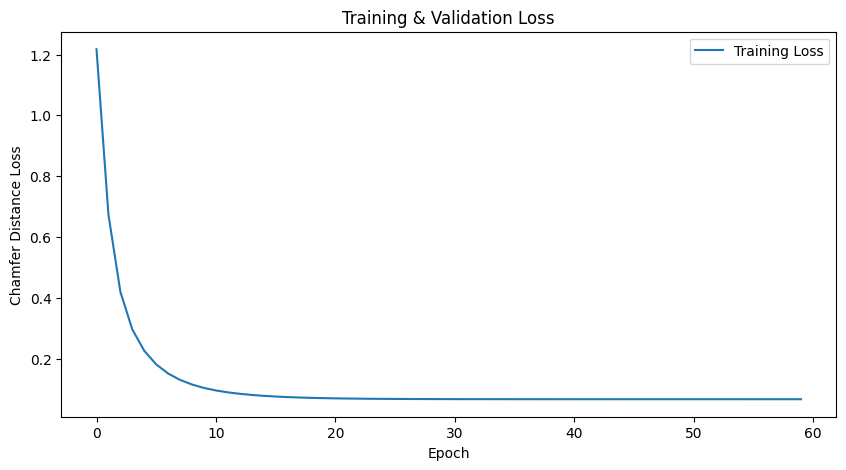

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

torch.Size([1, 3072])
tensor(0.0661)


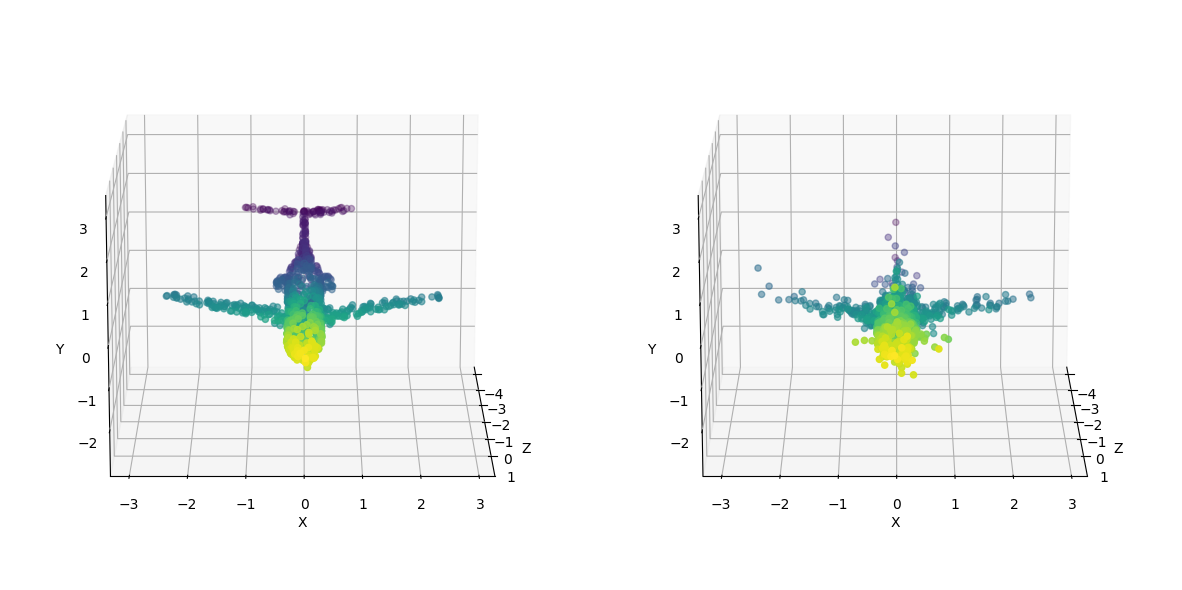

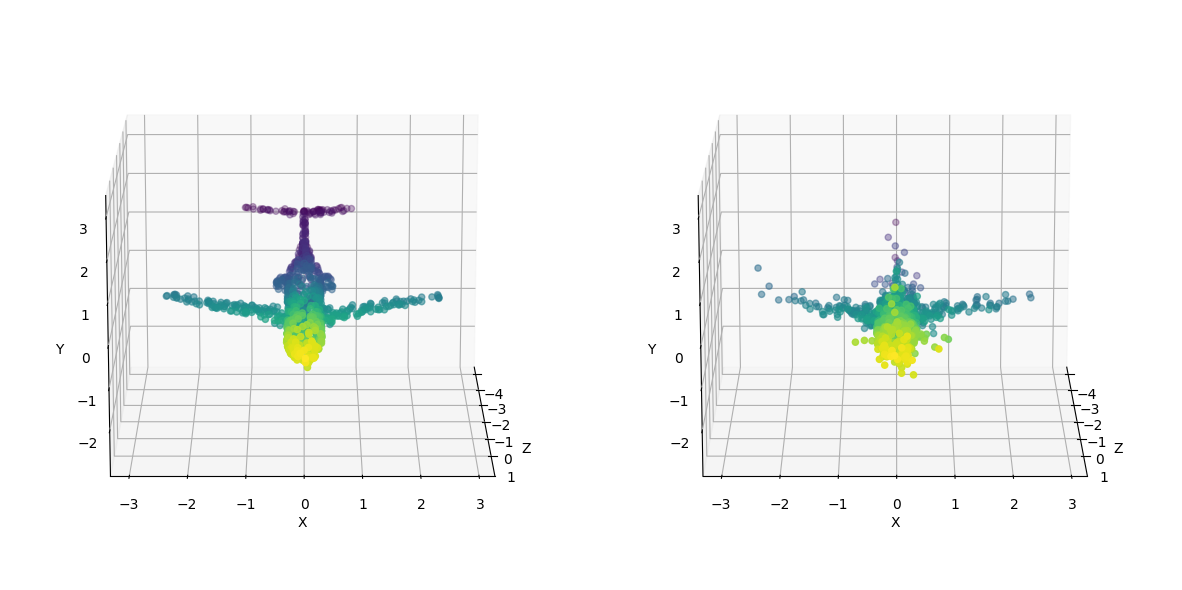

In [ ]:
model.eval()
input = torch.unsqueeze(dataset[0]['train_points'], dim=0)
with torch.no_grad():
  # output, _, _ = model(input.transpose(1, 2))
  output = model(input.view(1, 3*1024))
print(output.shape)
print(np_chamfer_distance(input, output.view(1, 1024, 3))[0])
visualize_pointcloud_eval(input.squeeze(), output.squeeze().view(1024, 3))